In [45]:
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [46]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


In [47]:
data = pd.read_csv('Folad.csv',index_col='<DTYYYYMMDD>',parse_dates=True)
data.drop(['<TICKER>','<VALUE>','<OPENINT>','<PER>','<OPEN>'],axis=1,inplace=True)
data.rename(columns={"<LAST>": 'close', "<HIGH>": 'high', "<LOW>": 'low', '<VOL>': 'volume', '<FIRST>': 'open','<CLOSE>': 'Adj Close'}, inplace=True)
data = data[['open','high','low','close','Adj Close','volume']]
data.index.name = 'Date'
data.head()

,open,high,low,close,Adj Close,volume
Date,,,,,,
2021-12-25,6900.0,7050.0,6830.0,7030.0,7010.0,148682550
2021-12-22,6520.0,6760.0,6520.0,6760.0,6720.0,47074157
2021-12-21,6220.0,6520.0,6220.0,6520.0,6440.0,58637932
2021-12-20,6250.0,6320.0,6150.0,6300.0,6210.0,49812577
2021-12-19,6340.0,6350.0,6110.0,6150.0,6160.0,32898343


<AxesSubplot:xlabel='Date'>

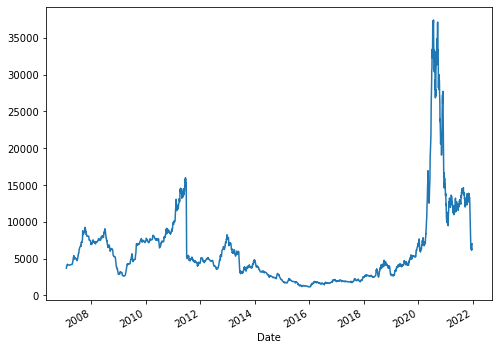

In [48]:
plt.figure(figsize=(8,6))
data['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

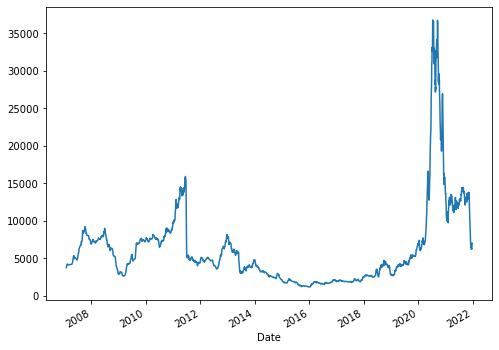

In [49]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)
plt.figure(figsize=(8,6))
data['Adj Close'].plot()

In [50]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [51]:
live_pred_data = data.iloc[-16:-11]
live_pred_data

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2007-03-19,4130.215384,13.286245,-137.999255,-168.012827,3.412133,4.124013e+10,76.782621,-55.305162,4.533263e-12,-1.527667,-6.398416e+09,-156.016060,-1412.097421,1.083085,0.928934,0.772625,0.909494,0.949664,0.990914,1.614848
2007-03-17,4110.575384,12.367199,-132.848252,-160.979912,10.958510,4.123864e+10,77.156060,-69.406807,3.012701e-12,-1.900295,-6.401256e+09,-192.092502,-1373.765591,1.095131,0.900029,0.772451,0.909088,0.948617,0.988475,2.470600
2007-03-14,4099.151384,11.853575,-128.209941,-154.425918,89.627685,4.195381e+10,178.918907,-73.692382,4.263256e-14,-2.063523,-7.156584e+09,-597.203700,-1370.574593,1.053542,0.377693,0.773789,0.910428,0.949400,0.988079,5.954693
2007-03-13,4106.852985,14.433607,-122.500483,-148.040831,90.406444,4.216033e+10,218.203760,-59.592334,2.745560e+01,-1.749510,-6.890964e+09,-181.129640,-1196.310053,1.030047,0.789915,0.778674,0.915796,0.954289,0.991598,1.771095
2007-02-20,4161.548545,30.084809,-112.268065,-140.886278,94.180455,4.223640e+10,231.117745,0.592683,3.409909e+01,-0.270684,-6.797117e+09,-45.865862,-1063.790789,1.023790,0.920334,0.792322,0.931040,0.969131,1.004001,0.667381


In [52]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.head()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2021-11-21,90.713705,260.819042,36.769871,96.626879,2.693068e+08,602.894513,4639.338294,41.857888,64.348094,-2.680811e+08,474.652366,1312.661254,0.941741,0.877885,1.599527,1.586322,1.574046,1.502451,0.888229,1.0
2021-11-17,92.893013,546.651511,141.699711,96.219713,2.552764e+08,695.318608,6050.148340,51.712514,92.788474,-2.310633e+08,309.931790,2388.028836,0.893282,0.941801,1.715423,1.684642,1.657427,1.517468,0.734325,1.0
2021-11-16,93.523554,793.045812,274.969909,96.060234,2.448618e+08,721.197373,6661.079128,60.102503,107.124109,-2.010547e+08,224.402314,3032.743698,0.830687,1.001194,1.701650,1.657135,1.619026,1.439731,0.640527,1.0
2021-11-15,93.739741,984.967052,419.574299,93.860328,2.288956e+08,740.049545,6874.879558,67.888586,108.236983,-1.684791e+08,177.635508,3465.107549,0.792974,1.045589,1.650080,1.596059,1.551024,1.354142,0.734051,0.0
2021-11-14,94.089602,1142.190219,566.210737,95.165856,2.057392e+08,772.383676,7294.214222,74.394103,115.046557,-1.312128e+08,153.049831,3782.753561,0.753869,1.067785,1.622350,1.560194,1.509575,1.301903,0.863558,0.0


In [55]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [56]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 20)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

In [60]:
def _train_GBT(X_train, y_train, X_test, y_test):

    gbt = GradientBoostingClassifier()
    # Dictionary of all values we want to test for n_estimators
    params_gbt = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_neighbors
    gbt_gs = GridSearchCV(gbt, params_gbt, cv=5)
    
    # Fit model to training data
    gbt_gs.fit(X_train, y_train)
    
    # Save best model
    gbt_best = gbt_gs.best_estimator_
     
    # Check best n_neigbors value
    print(gbt_gs.best_params_)
    
    prediction = gbt_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return gbt_best

In [63]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble

In [ ]:
# Split data into equal partitions of size len_train

num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
len_train = 40 # Length of each train-test set

# Lists to store the results from each model
rf_RESULTS = []
knn_RESULTS = []
ensemble_RESULTS = []

i = 0
while True:

    # Partition the data into chunks of size len_train every num_train days
    df = data.iloc[i * num_train : (i * num_train) + len_train]
    i += 1
    print(i * num_train, (i * num_train) + len_train)

    if len(df) < 40:
        break

    y = df['pred']
    features = [x for x in df.columns if x not in ['pred']]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)

    rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
    knn_model = _train_KNN(X_train, y_train, X_test, y_test)
    ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)

    rf_prediction = rf_model.predict(X_test)
    knn_prediction = knn_model.predict(X_test)
    ensemble_prediction = ensemble_model.predict(X_test)

    print('rf prediction is ', rf_prediction)
    print('knn prediction is ', knn_prediction)
    print('ensemble prediction is ', ensemble_prediction)
    print('truth values are ', y_test.values)

    rf_accuracy = accuracy_score(y_test.values, rf_prediction)
    knn_accuracy = accuracy_score(y_test.values, knn_prediction)
    ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

    print(rf_accuracy, knn_accuracy, ensemble_accuracy)
    rf_RESULTS.append(rf_accuracy)
    knn_RESULTS.append(knn_accuracy)
    ensemble_RESULTS.append(ensemble_accuracy)


print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))


In [64]:
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
2007-03-19,4130.215384,13.286245,-137.999255,-168.012827,3.412133,4.124013e+10,76.782621,-55.305162,4.533263e-12,-1.527667,-6.398416e+09,-156.016060,-1412.097421,1.083085,0.928934,0.772625,0.909494,0.949664,0.990914,1.614848
2007-03-17,4110.575384,12.367199,-132.848252,-160.979912,10.958510,4.123864e+10,77.156060,-69.406807,3.012701e-12,-1.900295,-6.401256e+09,-192.092502,-1373.765591,1.095131,0.900029,0.772451,0.909088,0.948617,0.988475,2.470600
2007-03-14,4099.151384,11.853575,-128.209941,-154.425918,89.627685,4.195381e+10,178.918907,-73.692382,4.263256e-14,-2.063523,-7.156584e+09,-597.203700,-1370.574593,1.053542,0.377693,0.773789,0.910428,0.949400,0.988079,5.954693
2007-03-13,4106.852985,14.433607,-122.500483,-148.040831,90.406444,4.216033e+10,218.203760,-59.592334,2.745560e+01,-1.749510,-6.890964e+09,-181.129640,-1196.310053,1.030047,0.789915,0.778674,0.915796,0.954289,0.991598,1.771095
2007-02-20,4161.548545,30.084809,-112.268065,-140.886278,94.180455,4.223640e+10,231.117745,0.592683,3.409909e+01,-0.270684,-6.797117e+09,-45.865862,-1063.790789,1.023790,0.920334,0.792322,0.931040,0.969131,1.004001,0.667381


In [14]:
del(live_pred_data['close'])
prediction = ensemble_model.predict(live_pred_data)
print(prediction)

[1. 1. 0. 0. 0.]


In [21]:
data.iloc[-16:-11]['pred']

Date
2017-02-22    0.0
2017-02-21    0.0
2017-02-20    0.0
2017-02-19    0.0
2017-02-18    0.0
Name: pred, dtype: float64

In [29]:
ensemble_model.predict(data.iloc[-46:-41].drop(['pred'],axis=1))

array([0., 0., 0., 0., 0.])

In [30]:
data.iloc[-46:-41]['pred']

Date
2017-04-16    0.0
2017-04-15    0.0
2017-04-12    0.0
2017-04-10    0.0
2017-04-09    0.0
Name: pred, dtype: float64

In [31]:
ensemble_model.predict(data.iloc[-26:-21].drop(['pred'],axis=1))

array([0., 0., 0., 0., 0.])

In [32]:
data.iloc[-26:-21]['pred']

Date
2017-03-08    0.0
2017-03-07    0.0
2017-03-06    0.0
2017-03-05    0.0
2017-03-04    0.0
Name: pred, dtype: float64

In [34]:
ensemble_model.predict(data.iloc[-96:-91].drop(['pred'],axis=1))

array([0., 0., 0., 0., 1.])

In [35]:
data.iloc[-96:-91]['pred']

Date
2017-07-02    0.0
2017-07-01    1.0
2017-06-28    1.0
2017-06-25    1.0
2017-06-24    1.0
Name: pred, dtype: float64